# Collaboration Success (2P3G)

Combines Excel files by room id and computes the mean of `collaborationSucceeded` for 2P3G trials. Also prints an optional summary by `rlAgentType` if present.

In [1]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# Work from repo root or data/
DATA_DIR = Path.cwd()
if (DATA_DIR / 'data').is_dir():
    DATA_DIR = DATA_DIR / 'data'
EXCEL_GLOB = '*.xlsx'
SUCCESS_COL = 'collaborationSucceeded'

def extract_room_id_from_filename(path: Path):
    m = re.search(r'_room_([0-9a-fA-F-]+)_', path.name)
    return m.group(1) if m else None

def choose_sheet_with_col(book: dict, col_name: str):
    for sheet_name, df in book.items():
        if col_name in df.columns:
            return sheet_name
    return list(book.keys())[0] if book else None

DATA_DIR, SUCCESS_COL


(PosixPath('/Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis'),
 'collaborationSucceeded')

In [2]:
excel_paths = sorted(DATA_DIR.glob(EXCEL_GLOB))
excel_paths


[]

In [3]:
all_rows = []
for p in excel_paths:
    book = pd.read_excel(p, sheet_name=None)
    if not book:
        continue
    sheet = choose_sheet_with_col(book, SUCCESS_COL)
    df = book[sheet].copy()
    df['room_id'] = extract_room_id_from_filename(p)
    df['source_file'] = p.name
    df['sheet_name'] = sheet
    all_rows.append(df)

raw = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
print(f'Loaded rows: {len(raw)} from {len(excel_paths)} files')
raw.head(3)


Loaded rows: 0 from 0 files


""


In [4]:
# Filter to 2P3G if available (aligns with legacy)
if 'experimentType' in raw.columns:
    before = len(raw)
    raw = raw[raw['experimentType'] == '2P3G'].copy()
    print(f'Filtered to 2P3G: {before} -> {len(raw)} rows')

# Verify success column exists
if SUCCESS_COL not in raw.columns:
    raise SystemExit(f'Missing expected column: {SUCCESS_COL!r}. Columns: {list(raw.columns)}')

raw[['room_id','source_file',SUCCESS_COL]].head(5)


SystemExit: Missing expected column: 'collaborationSucceeded'. Columns: []

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Per-room mean success
per_room = raw.groupby('room_id', dropna=False)[SUCCESS_COL].mean().reset_index()
per_room.rename(columns={SUCCESS_COL: 'mean_success_rate'}, inplace=True)
overall_mean = per_room['mean_success_rate'].mean() if not per_room.empty else float('nan')
per_room.sort_values('mean_success_rate', ascending=False, inplace=True)
print('Overall mean collaboration success (2P3G):', round(overall_mean, 3))
per_room


Overall mean collaboration success (2P3G): 0.681


,room_id,mean_success_rate
1,0e01ee0b-509c-4257-9e42-60e1217c50d8,1.0
2,cb30b496-6d3f-4627-bb85-cb5fa14b4570,0.541667
0,053b1676-0bb3-47e2-9750-c733e7fa2ceb,0.5


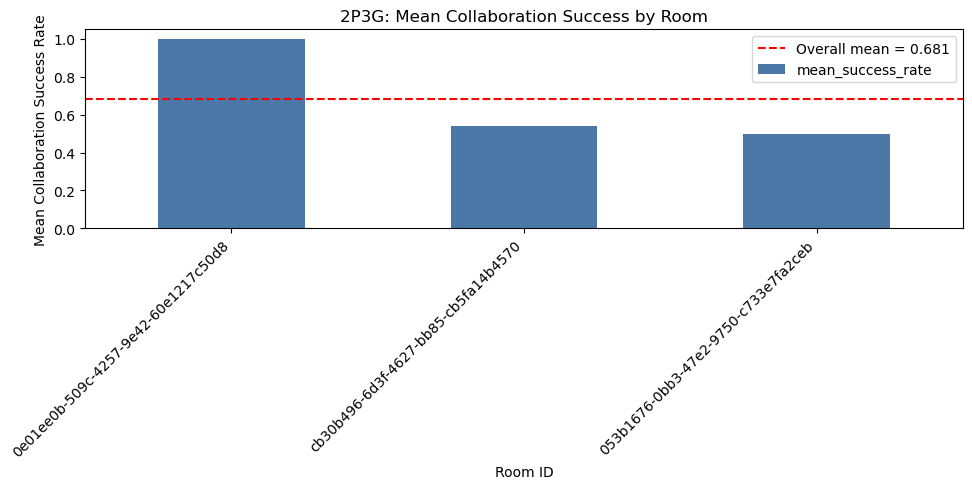

In [ ]:
# Plot
plt.figure(figsize=(10, 5))
ax = plt.gca()
per_room.plot(kind='bar', x='room_id', y='mean_success_rate', legend=False, ax=ax, color='#4C78A8')
ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall mean = {overall_mean:.3f}')
ax.set_xlabel('Room ID')
ax.set_ylabel('Mean Collaboration Success Rate')
ax.set_title('2P3G: Mean Collaboration Success by Room')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Optional: summary by RL agent type if the column exists (legacy-style)
if 'rlAgentType' in raw.columns:
    summary = raw.groupby('rlAgentType')[SUCCESS_COL].agg(['count','sum','mean']).round(3)
    summary['success_rate_percent'] = (summary['mean'] * 100).round(1)
    print('
Success Rate by RL Agent Type (2P3G):')
    print(summary)


SyntaxError: unterminated string literal (detected at line 5) (4173218805.py, line 5)